# **Assignment 2: Instruction**

Submission date: 7/10/2022


---



On kneeXRay dataset, you are required to prepare one notebook that can run on google colab containing:

1.   The training of a **model on the dataset as is.(as in fruit data notebook)
2.   The training of the model using custom CNN of three hidden layers on the dataset after modification with batchnorm and dropout to improve the performance of the model.
3.   The training of the model using transfer learning on the dataset
4.   Save the final model and load again on the notebook. Perform inference on 3 new samples (provided separately) 


---



* The deliverables: one notebook containing all the codes, model file (.pt file) and inference on three images 

# **Dataset description**
https://drive.google.com/file/d/1v6aLMBb4w8QkIciqy34Sh_hOFeWQWm9j/view?usp=sharing

This dataset contains knee X-ray data for both knee joint detection and knee KL grading. The Grade descriptions are as follows:
*   **Grade 0**: Healthy knee image.
*   **Grade 1** (Doubtful): Doubtful joint narrowing with possible osteophytic lipping
*   **Grade 2** (Minimal): Definite presence of osteophytes and possible joint space narrowing
*   **Grade 3** (Moderate): Multiple osteophytes, definite joint space narrowing, with mild sclerosis.
*   **Grade 4** (Severe): Large osteophytes, significant joint narrowing, and severe sclerosis.



---



---


Acknowledgements:

Chen, Pingjun (2018), “Knee Osteoarthritis Severity Grading Dataset”, Mendeley Data, V1, doi: 10.17632/56rmx5bjcr.1
The dataset is organized from OAI.

In [ ]:
#mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!gdown 1v6aLMBb4w8QkIciqy34Sh_hOFeWQWm9j

Downloading...
From: https://drive.google.com/uc?id=1v6aLMBb4w8QkIciqy34Sh_hOFeWQWm9j
To: /content/kneeXray.zip
100% 145M/145M [00:00<00:00, 164MB/s]


In [ ]:
!unzip kneeXray.zip -d /content/gdrive/MyDrive/kneeXray_dataset

Streaming output truncated to the last 5000 lines.
 extracting: /content/gdrive/MyDrive/kneeXray_dataset/kneeXray/train/0/9687273L.png  
 extracting: /content/gdrive/MyDrive/kneeXray_dataset/kneeXray/train/0/9689906R.png  
 extracting: /content/gdrive/MyDrive/kneeXray_dataset/kneeXray/train/0/9690910L.png  
 extracting: /content/gdrive/MyDrive/kneeXray_dataset/kneeXray/train/0/9690910R.png  
 extracting: /content/gdrive/MyDrive/kneeXray_dataset/kneeXray/train/0/9691359L.png  
 extracting: /content/gdrive/MyDrive/kneeXray_dataset/kneeXray/train/0/9691359R.png  
 extracting: /content/gdrive/MyDrive/kneeXray_dataset/kneeXray/train/0/9692163L.png  
 extracting: /content/gdrive/MyDrive/kneeXray_dataset/kneeXray/train/0/9692604L.png  
 extracting: /content/gdrive/MyDrive/kneeXray_dataset/kneeXray/train/0/9692604R.png  
 extracting: /content/gdrive/MyDrive/kneeXray_dataset/kneeXray/train/0/9692923R.png  
 extracting: /content/gdrive/MyDrive/kneeXray_dataset/kneeXray/train/0/9693364R.png  
 ex

# Q1 - Model training as in fruit_dataset notebook

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [ ]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


In [ ]:
# Load the Data

# Set train and valid directory paths

from google.colab import drive
drive.mount('/content/gdrive')

dataset = '/content/gdrive/My Drive/kneeXray_dataset/kneeXray'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 32

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
5


Let's see the info on train dataset

In [ ]:
data['train']

Dataset ImageFolder
    Number of datapoints: 5778
    Root location: /content/gdrive/My Drive/kneeXray_dataset/kneeXray/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [ ]:
train_data_size, test_data_size

(5778, 826)

In [ ]:
input_size = (3,32,32)

In [ ]:
# #######################################################
# #                  Create Dataloader                     #
# #######################################################

# # Turn train and test custom Dataset's into DataLoader's
# from torch.utils.data import DataLoader
# trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
#                                      batch_size=4, # how many samples per batch?
#                                      num_workers=0, # how many subprocesses to use for data loading? (higher = more)
#                                      shuffle=True) # shuffle the data?

# testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
#                                     batch_size=4, 
#                                     num_workers=0, 
#                                     shuffle=False) # don't usually need to shuffle testing data

# train_data_size = len(trainloader.dataset)
# test_data_size = len(testloader.dataset)

# print(train_data_size)
# print(test_data_size)

In [ ]:
#######################
# DEFINE YOUR OWN MODEL

model_ft = models.convnext_tiny(pretrained=True)
num_ftrs = model_ft.classifier[2].in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[2] = nn.Linear(num_ftrs, 5)

#######################

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96

In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'kneeXray_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
# 4. Train the model for 10 epochs
 
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.4175, Accuracy: 39.1139%, 
		Validation : Loss : 1.4031, Accuracy: 39.7094%, Time: 1738.2944s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.4036, Accuracy: 39.3908%, 
		Validation : Loss : 1.3932, Accuracy: 39.7094%, Time: 191.2982s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.3824, Accuracy: 39.4946%, 
		Validation : Loss : 1.3122, Accuracy: 41.6465%, Time: 194.5368s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.1811, Accuracy: 49.4981%, 
		Validation : Loss : 1.0623, Accuracy: 54.3584%, Time: 196.2469s
Epoch: 5/10
Epoch : 004, Training: Loss: 1.0570, Accuracy: 55.4690%, 
		Validation : Loss : 1.0303, Accuracy: 56.4165%, Time: 195.3693s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.9782, Accuracy: 57.7362%, 
		Validation : Loss : 0.9325, Accuracy: 61.1380%, Time: 195.7434s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.9402, Accuracy: 60.4708%, 
		Validation : Loss : 0.8859, Accuracy: 63.0751%, Time: 195.4011s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.9345

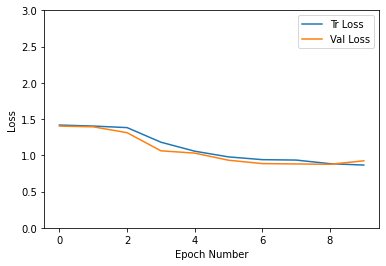

In [ ]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('kneeXray_loss_curve.png')
plt.show()

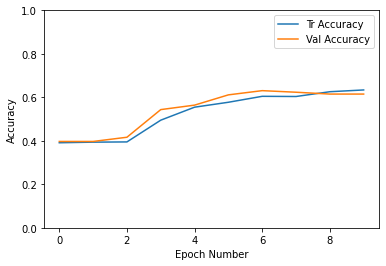

In [ ]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('kneeXray_accuracy_curve.png')
plt.show()

# Q2 - Model training using custom CNN of three hidden layers with batchnorm and dropout

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [ ]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# Load the Data

# Set train and valid directory paths

from google.colab import drive
drive.mount('/content/gdrive')

dataset = '/content/gdrive/My Drive/kneeXray_dataset/kneeXray'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

transform = transforms.Compose(
    [transforms.Resize(64),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

# Batch size
batchSize = 32

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Classes
classes = ('0', '1', '2', '3', '4')

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
                                  #transform=transform),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
                                 #transform=transforms)
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

Mounted at /content/gdrive
5


In [ ]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle=False)

In [ ]:
#1. DEFINE THE CNN 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)  #arguments: in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 15, 3)
        self.batchnorm2 = nn.BatchNorm2d(15)
        self.conv3 = nn.Conv2d(15, 20, 3)
        self.fc1 = nn.Linear(20 * 6 * 6, 100)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(100, 200)
        self.fc3 = nn.Linear(200, 10)
        self.fc4 = nn.Linear(10, 5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.batchnorm(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.batchnorm2(x)
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 20 * 6 * 6)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
model = CNN() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=720, out_features=100, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=5, bias=True)
  (relu): ReLU()
)

In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'kneeXray_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
import torch
from torchvision import models
from torchsummary import summary

model = CNN()
model.to(device)
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 60, 60]             760
              ReLU-2           [-1, 10, 60, 60]               0
         MaxPool2d-3           [-1, 10, 30, 30]               0
       BatchNorm2d-4           [-1, 10, 30, 30]              20
            Conv2d-5           [-1, 15, 28, 28]           1,365
              ReLU-6           [-1, 15, 28, 28]               0
         MaxPool2d-7           [-1, 15, 14, 14]               0
       BatchNorm2d-8           [-1, 15, 14, 14]              30
            Conv2d-9           [-1, 20, 12, 12]           2,720
             ReLU-10           [-1, 20, 12, 12]               0
        MaxPool2d-11             [-1, 20, 6, 6]               0
           Linear-12                  [-1, 100]          72,100
             ReLU-13                  [-1, 100]               0
          Dropout-14                  [

In [ ]:
# 4. Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.6023, Accuracy: 13.3091%, 
		Validation : Loss : 1.6037, Accuracy: 12.8329%, Time: 3453.7542s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.6024, Accuracy: 13.3091%, 
		Validation : Loss : 1.6038, Accuracy: 12.8329%, Time: 27.3194s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.6026, Accuracy: 13.2226%, 
		Validation : Loss : 1.6038, Accuracy: 12.8329%, Time: 28.1381s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.6022, Accuracy: 13.3264%, 
		Validation : Loss : 1.6037, Accuracy: 12.8329%, Time: 27.2008s
Epoch: 5/10
Epoch : 004, Training: Loss: 1.6022, Accuracy: 13.4129%, 
		Validation : Loss : 1.6037, Accuracy: 12.8329%, Time: 27.4416s
Epoch: 6/10
Epoch : 005, Training: Loss: 1.6025, Accuracy: 13.2918%, 
		Validation : Loss : 1.6036, Accuracy: 12.8329%, Time: 27.3929s
Epoch: 7/10
Epoch : 006, Training: Loss: 1.6025, Accuracy: 13.2226%, 
		Validation : Loss : 1.6037, Accuracy: 12.8329%, Time: 28.4102s
Epoch: 8/10
Epoch : 007, Training: Loss: 1.6024, Accu

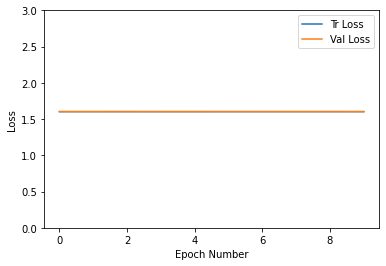

In [ ]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('kneeXray_loss_curve.png')
plt.show()

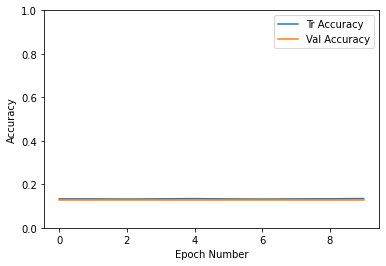

In [ ]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('kneeXray_accuracy_curve.png')
plt.show()

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 12 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 0.0 %
Accuracy for class: 1     is 0.0 %
Accuracy for class: 2     is 0.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 0.0 %


# Q3 - Model training using transfer learning

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [ ]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


In [ ]:
# Load the Data

# Set train and valid directory paths

from google.colab import drive
drive.mount('/content/gdrive')

dataset = '/content/gdrive/My Drive/kneeXray_dataset/kneeXray'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 32

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

Mounted at /content/gdrive
5


Let's see the info on train dataset

In [ ]:
data['train']

Dataset ImageFolder
    Number of datapoints: 5778
    Root location: /content/gdrive/My Drive/kneeXray_dataset/kneeXray/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [ ]:
train_data_size, test_data_size

(5778, 826)

In [ ]:
input_size = (3,32,32)

In [ ]:
#######################
# DEFINE YOUR OWN MODEL

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

#######################

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'kneeXray_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
# 4. Train the model for 10 epochs
 
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.3123, Accuracy: 44.0983%, 
		Validation : Loss : 1.1506, Accuracy: 51.5738%, Time: 910.8838s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.0777, Accuracy: 54.0845%, 
		Validation : Loss : 1.1617, Accuracy: 54.2373%, Time: 46.3602s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.9986, Accuracy: 57.9439%, 
		Validation : Loss : 0.9767, Accuracy: 57.3850%, Time: 47.5313s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.9420, Accuracy: 59.6919%, 
		Validation : Loss : 1.0015, Accuracy: 58.1114%, Time: 47.5007s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.9058, Accuracy: 61.5957%, 
		Validation : Loss : 0.9354, Accuracy: 61.6223%, Time: 47.8663s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.8718, Accuracy: 63.1706%, 
		Validation : Loss : 0.9723, Accuracy: 59.4431%, Time: 47.3564s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.8577, Accuracy: 64.1225%, 
		Validation : Loss : 0.9827, Accuracy: 61.8644%, Time: 47.4711s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.8362, Accur

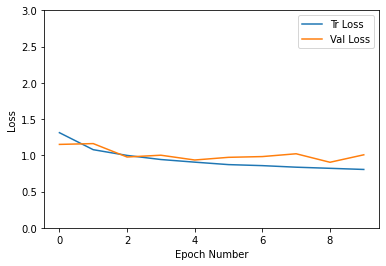

In [ ]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('kneeXray_loss_curve.png')
plt.show()

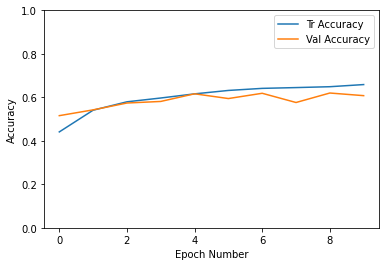

In [ ]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('kneeXray_accuracy_curve.png')
plt.show()

# Q4 - Inference on 3 new samples

In [ ]:
transform = transforms.Compose([transforms.ToPILImage(),         
                                transforms.Resize(256),                    
                                transforms.CenterCrop(224),                
                                transforms.ToTensor(),                     
                                transforms.Normalize(                      
                                    mean=[0.485, 0.456, 0.406],                
                                    std=[0.229, 0.224, 0.225]                  
                                )])

classes = ['0_normal', '1_doubtful', '2_mild', '3_moderate', '4_severe']

2_mild 0.7034422755241394


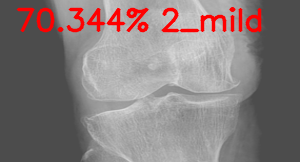

In [ ]:
img = cv2.imread("/content/gdrive/MyDrive/new_test_images/test_image_1.png")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   
img_t = transform(img)

input_batch = torch.unsqueeze(img_t, 0)
input_batch = input_batch.to(device)
trained_model.eval()

# Carry out inference
out = trained_model(input_batch)

from google.colab.patches import cv2_imshow

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities, 5)

cv2.putText(img, f"{top5_prob[0].item()*100:.3f}%", (15, (1)*30), 
            cv2.FONT_HERSHEY_SIMPLEX,
            1, (0, 0, 255), 2, cv2.LINE_AA)
cv2.putText(img, f"{classes[top5_catid[i]]}", (160, (1)*30), 
            cv2.FONT_HERSHEY_SIMPLEX,
            1, (0, 0, 255), 2, cv2.LINE_AA)
print(classes[top5_catid[0]], top5_prob[0].item())
    
cv2_imshow(img)


0_normal 0.9241845607757568


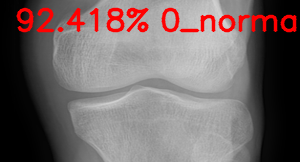

In [ ]:
img = cv2.imread("/content/gdrive/MyDrive/new_test_images/test_image_2.png")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   
img_t = transform(img)

input_batch = torch.unsqueeze(img_t, 0)
input_batch = input_batch.to(device)
trained_model.eval()

# Carry out inference
out = trained_model(input_batch)

from google.colab.patches import cv2_imshow

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities, 5)

cv2.putText(img, f"{top5_prob[0].item()*100:.3f}%", (15, (1)*30), 
            cv2.FONT_HERSHEY_SIMPLEX,
            1, (0, 0, 255), 2, cv2.LINE_AA)
cv2.putText(img, f"{classes[top5_catid[i]]}", (160, (1)*30), 
            cv2.FONT_HERSHEY_SIMPLEX,
            1, (0, 0, 255), 2, cv2.LINE_AA)
print(classes[top5_catid[0]], top5_prob[0].item())
    
cv2_imshow(img)

3_moderate 0.5906456112861633


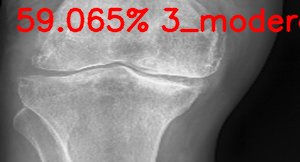

In [ ]:
img = cv2.imread("/content/gdrive/MyDrive/new_test_images/test_image_3.png")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   
img_t = transform(img)

input_batch = torch.unsqueeze(img_t, 0)
input_batch = input_batch.to(device)
trained_model.eval()

# Carry out inference
out = trained_model(input_batch)

from google.colab.patches import cv2_imshow

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities, 5)

cv2.putText(img, f"{top5_prob[0].item()*100:.3f}%", (15, (1)*30), 
            cv2.FONT_HERSHEY_SIMPLEX,
            1, (0, 0, 255), 2, cv2.LINE_AA)
cv2.putText(img, f"{classes[top5_catid[i]]}", (160, (1)*30), 
            cv2.FONT_HERSHEY_SIMPLEX,
            1, (0, 0, 255), 2, cv2.LINE_AA)
print(classes[top5_catid[0]], top5_prob[0].item())
    
cv2_imshow(img)